In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization,LSTM

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


In [5]:
flu_df = pd.read_csv('data/clean_flu_data.csv').sort_values('date')
print(flu_df.shape)
flu_df.head()

(461, 51)


,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Nebraska,New Mexico,...,Maine,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,2.199780,2.13191,...,0.357724,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,2.735320,1.96350,...,0.434855,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,3.311030,1.67486,...,0.421743,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,2.057610,2.35498,...,0.338409,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,0.376712,2.37983,...,0.176471,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,0.971705


In [6]:
texas_gt = pd.read_csv('data/google_clean/Texas.csv')
pd.merge(texas_gt, flu_df, on = 'date', how = 'left')

,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,Maine,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,Colorado
0,2010-40,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,10.0,...,0.357724,1.666830,0.414938,0.747696,1.143430,0.262990,2.80877,0.624179,1.102750,0.660684
1,2010-41,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,10.0,...,0.434855,1.636330,1.457980,0.410939,1.236530,0.369729,2.89079,0.958678,0.793794,0.628621
2,2010-42,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,10.0,...,0.421743,1.508600,1.408140,0.440583,1.225450,0.362121,2.41042,2.070390,0.791023,0.804020
3,2010-43,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,10.0,...,0.338409,2.144510,1.280070,0.755957,1.269020,0.358981,3.11632,1.670730,0.801311,0.909658
4,2010-44,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,10.0,...,0.176471,1.767610,1.827240,0.651859,1.265470,0.527357,2.99118,1.628450,0.779833,0.971705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2019-27,7.0,0.0,0.0,50.0,3.0,1.0,4.0,1.0,29.0,...,0.604772,0.546315,0.000100,1.585350,0.927170,0.678007,3.95861,0.424056,0.360427,1.043860
457,2019-28,7.0,0.0,0.0,50.0,3.0,1.0,4.0,1.0,29.0,...,0.558624,0.497344,0.000100,1.197440,0.900846,0.607034,4.21128,0.361664,0.503960,0.959798
458,2019-29,7.0,0.0,0.0,50.0,3.0,1.0,4.0,1.0,29.0,...,0.448547,0.588998,0.000100,1.313940,0.870202,0.494300,4.04040,0.380417,0.368135,0.999950
459,2019-30,7.0,0.0,0.0,50.0,3.0,1.0,4.0,1.0,29.0,...,0.511751,0.423831,0.000100,1.344060,0.800792,0.511351,3.19149,0.312256,0.316957,0.921444


### Vanilla NN model

In [49]:
def VanillaNN(state,if_plot=True,if_gt = None):
    # def Neural network
    def NN(X_train,y_train,batch_size,epochs,verbose):
        n_units = 100
        drop_rate = .1
        dim_embed = 50
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = batch_size
        epochs = epochs
        validation_split = 0.1
        verbose = verbose
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(input_dim=len(X_train.keys()),units = 64,activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
        model.add(tf.keras.layers.Dense(units = 64,activation = 'relu'))
        model.add(tf.keras.layers.Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X = flu_df.drop(columns = ['date',state])
    X_train = X[0:size]
    X_test =  X[size:-1]
    if if_gt == True:
        path = 'data/google_clean/' + state + '.csv'
        state_gt = pd.read_csv(path)
        X = pd.merge(texas_gt, flu_df, on = 'date', how = 'left').drop(columns = ['date',state])
    # Get google trend data
    train_path = 'data/state_flu_goolge/train/' +  state + '.csv'
    test_path = 'data/state_flu_goolge/test/' +  state + '.csv'
    state_gt_train = pd.read_csv(train_path)
    state_gt_test = pd.read_csv(test_path)
    # Get y value
    y_train = state_gt_train['target']
    y_test = state_gt_test['target']
    # Training Model
    preds = []
    for t in range(len(y_test)):
        X_train, X_test = X[:size+t], X[size+t:-1]
        nn = NN(X_train,y_train,32,10,0)
        pred = nn.predict(X_test)
        preds.append(pred[0])
        y_train = np.hstack([y_train,y_test[t]])
    
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show() 

Test RMSE:  1.6719024469415253


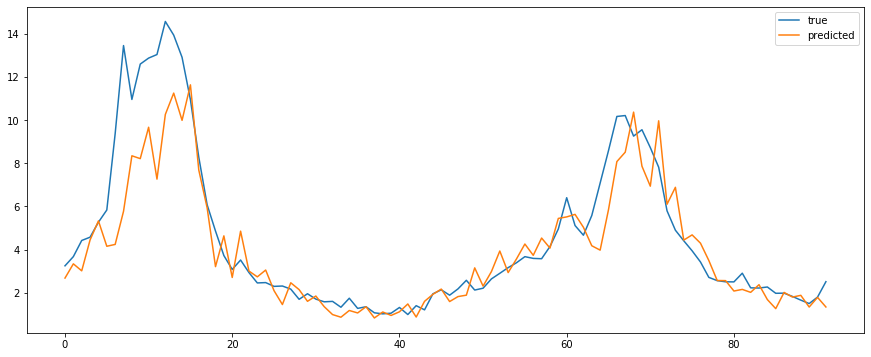

In [42]:
# Without Google Trend
VanillaNN('Texas',if_plot=True)

Test RMSE:  2.4584347759540006


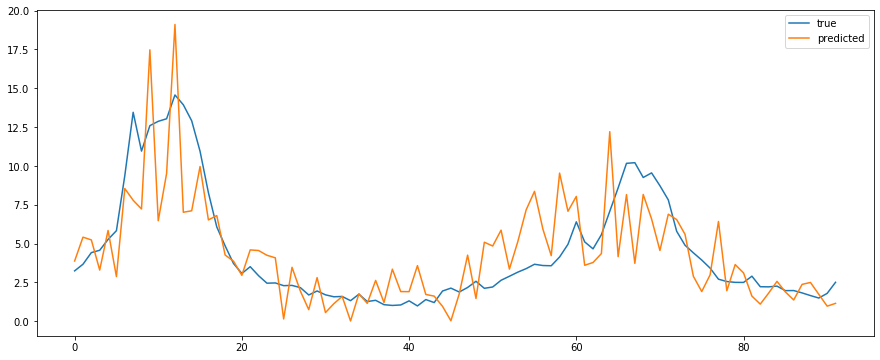

In [50]:
# With goolge trend
VanillaNN('Texas',if_plot=True,if_gt=True)

### RNN Model

In [233]:
def RNN(state,if_plot=True,if_gt = None):
    # def Neural network
    def rnn(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = 32
        epochs = 10
        validation_split = 0.1
        verbose = 0
        model = tf.keras.models.Sequential()
        model.add(SimpleRNN(64, input_shape = (1,X_train.shape[2]),
                            return_sequences= False,dropout=0.1, recurrent_dropout=0.1))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X = flu_df.drop(columns = ['date',state])
    X_train = X[0:size]
    X_test =  X[size:-1]
    if if_gt == True:
        path = 'data/google_clean/' + state + '.csv'
        state_gt = pd.read_csv(path)
        X = pd.merge(texas_gt, flu_df, on = 'date', how = 'left').drop(columns = ['date',state])
    # Get google trend data
    train_path = 'data/state_flu_goolge/train/' +  state + '.csv'
    test_path = 'data/state_flu_goolge/test/' +  state + '.csv'
    state_gt_train = pd.read_csv(train_path)
    state_gt_test = pd.read_csv(test_path)
    # Get y value
    y_train = state_gt_train['target']
    y_test = state_gt_test['target']
    # Training Model
    preds = []
    for t in range(len(y_test)):
        X_train, X_test = X[:size+t], X[size+t:-1]
        nn = rnn(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
                 np.asarray(y_train),32,10,0)
        pred = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
        preds.append(pred[0])
        y_train = np.hstack([y_train,y_test[t]])
    
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show() 

Test RMSE:  2.213664034925295


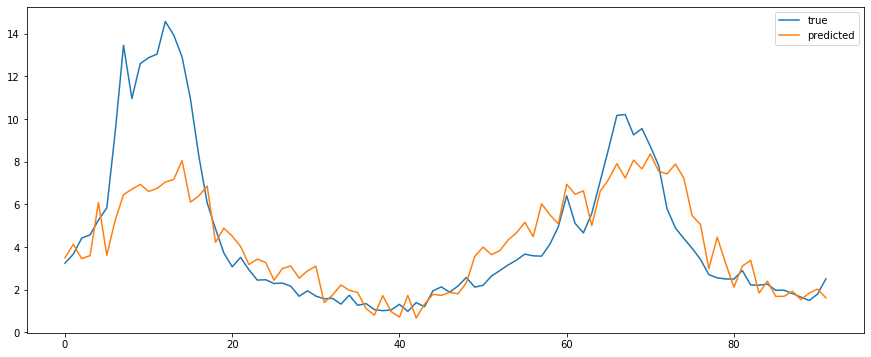

In [234]:
RNN('Texas',if_plot=True,if_gt = None)

Test RMSE:  2.560774813515289


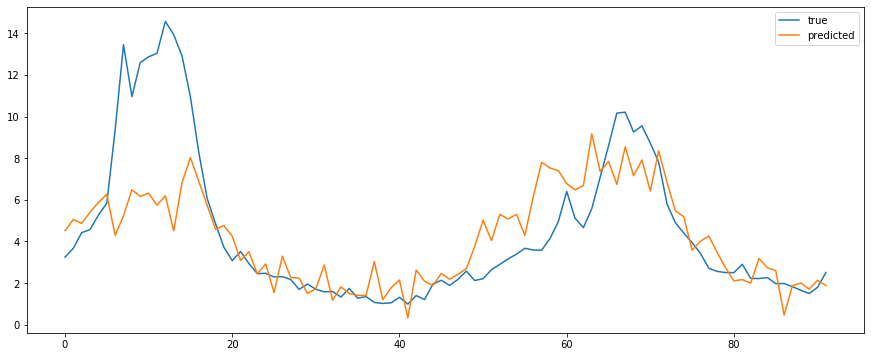

In [235]:
RNN('Texas',if_plot=True,if_gt = True)

In [12]:
def LSTM_model(state,if_plot=True,if_gt = None):
    # def Neural network
    def lstm(X_train,y_train,batch_size,epochs,verbose):
        optimizer = "rmsprop"
        loss = "mse"
        batch_size = 32
        epochs = 10
        validation_split = 0.1
        verbose = 0
        model = tf.keras.models.Sequential()
        model.add(LSTM(50, input_shape = (1,X_train.shape[2]),
                            return_sequences= True))
        model.add(Dropout(0.2))
        model.add(LSTM(100, return_sequences= False))
        model.add(Dropout(0.2))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
        return model
    #data
    size = 368
    X = flu_df.drop(columns = ['date',state])
    X_train = X[0:size]
    X_test =  X[size:-1]
    if if_gt == True:
        path = 'data/google_clean/' + state + '.csv'
        state_gt = pd.read_csv(path)
        X = pd.merge(texas_gt, flu_df, on = 'date', how = 'left').drop(columns = ['date',state])
    # Get google trend data
    train_path = 'data/state_flu_google/train/' +  state + '.csv'
    test_path = 'data/state_flu_google/test/' +  state + '.csv'
    state_gt_train = pd.read_csv(train_path)
    state_gt_test = pd.read_csv(test_path)
    # Get y value
    y_train = state_gt_train['target']
    y_test = state_gt_test['target']
    # Training Model
    preds = []
    for t in range(len(y_test)):
        X_train, X_test = X[:size+t], X[size+t:-1]
        nn = lstm(X_train.values.reshape(X_train.shape[0],1,X_train.shape[1]),
                 np.asarray(y_train),32,10,0)
        pred = nn.predict(X_test.values.reshape(X_test.shape[0],1,X_test.shape[1]))
        preds.append(pred[0])
        y_train = np.hstack([y_train,y_test[t]])
    
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show() 

Test RMSE:  2.2521749724610474


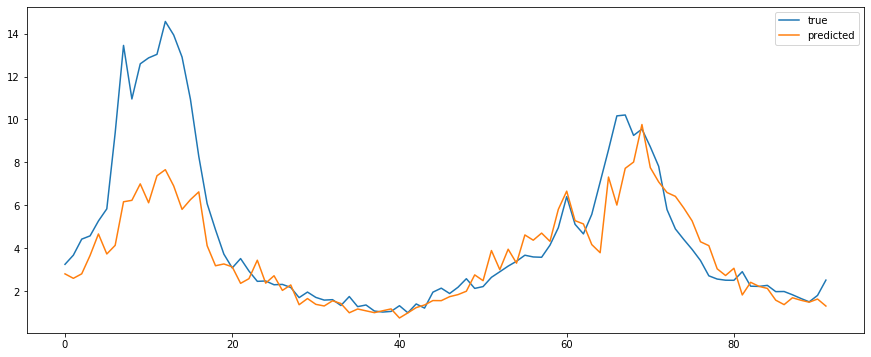

In [15]:
LSTM_model('Texas',if_plot=True,if_gt = None)

Test RMSE:  2.8383981152954116


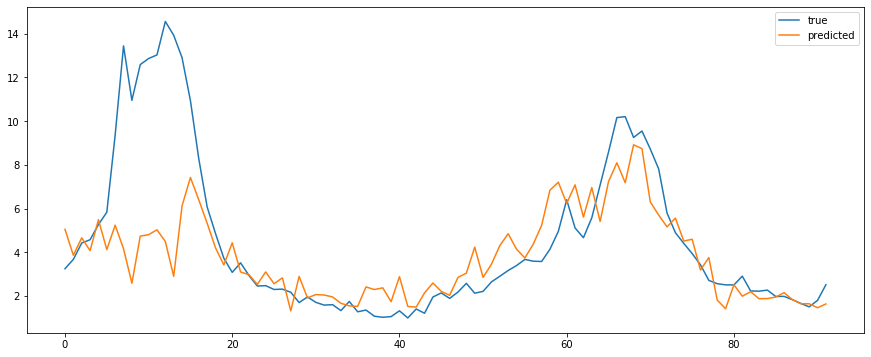

In [16]:
LSTM_model('Texas',if_plot=True,if_gt = True)